# (5주차) 4월4일 -- draft

- toc:true
- branch: master
- badges: true
- comments: true
- author: 최규빈

In [12]:
#!conda install -c conda-forge python-graphviz -y

In [1]:
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
import tensorflow.experimental.numpy as tnp 

In [3]:
tnp.experimental_enable_numpy_behavior() 

### 회귀분석 문제

`-` ${\bf y} \approx 4 + 2.5 {\bf x}$

In [8]:
tnp.random.seed(43052)
N = 200
x = tnp.linspace(0,1,N) 
epsilon = tnp.random.randn(N)*0.5
y = 2.5+4*x + epsilon
y_true = 2.5+4*x

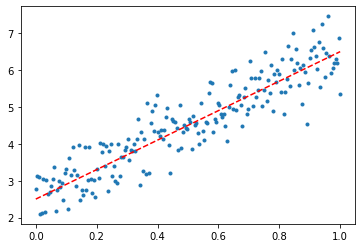

In [9]:
plt.plot(x,y,'.')
plt.plot(x,y_true,'r--')

### 이론적 풀이

#### 풀이1: 스칼라버전

`-` 포인트 
- $S_{xx}=$, $S_{xy}=$
- $\hat{\beta}_0=$, $\hat{\beta}_1=$

In [10]:
x.shape,y.shape

(TensorShape([200]), TensorShape([200]))

In [11]:
Sxx=sum((x-x.mean())**2)
Sxy=sum((x-x.mean())*(y-y.mean()))

In [12]:
beta1_hat = Sxy/Sxx
beta0_hat = y.mean() - beta1_hat *x.mean()

In [13]:
beta0_hat, beta1_hat

(<tf.Tensor: shape=(), dtype=float64, numpy=2.583667211565867>,
 <tf.Tensor: shape=(), dtype=float64, numpy=3.933034516733168>)

#### 풀이2: 벡터버전

`-` 포인트
- $\hat{\beta}=(X'X)^{-1}X'y$

In [14]:
X=tf.stack([tf.ones(N,dtype='float64'),x],axis=1)
y=y.reshape(N,1) 

In [15]:
X.shape,y.shape

(TensorShape([200, 2]), TensorShape([200, 1]))

In [16]:
tf.linalg.inv(X.T @ X) @ X.T @ y

<tf.Tensor: shape=(2, 1), dtype=float64, numpy=
array([[2.58366721],
       [3.93303452]])>

#### 풀이3: 벡터버전, 손실함수의 도함수이용 

`-` 포인트
- $loss'(\beta)=-2X'y +2X'X\beta$
- $\beta_{new} = \beta_{old} - \alpha \times loss'(\beta_{old})$

In [17]:
y=y.reshape(N,1)
X.shape,y.shape

(TensorShape([200, 2]), TensorShape([200, 1]))

In [18]:
beta_hat = tnp.array([-5,10]).reshape(2,1)
beta_hat

<tf.Tensor: shape=(2, 1), dtype=int64, numpy=
array([[-5],
       [10]])>

In [19]:
alpha=0.1

$loss'(\beta) = -2X'y+2X'X\beta$

In [20]:
slope = -2*X.T @ y + 2*X.T@ X @ beta_hat 
slope

<tf.Tensor: shape=(2, 1), dtype=float64, numpy=
array([[-1820.07378797],
       [ -705.77222696]])>

In [21]:
step = - alpha*slope
step 

<tf.Tensor: shape=(2, 1), dtype=float64, numpy=
array([[182.0073788],
       [ 70.5772227]])>

In [22]:
for epoc in range(1000):
    slope = (-2*X.T @ y + 2*X.T@ X @ beta_hat)/N
    step = - alpha * slope
    beta_hat = beta_hat + step 

In [23]:
beta_hat

<tf.Tensor: shape=(2, 1), dtype=float64, numpy=
array([[2.58366061],
       [3.93304684]])>

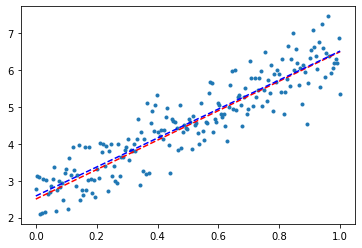

In [24]:
plt.plot(x,y,'.') 
plt.plot(x,y_true,'r--')
plt.plot(x,X@beta_hat,'b--')

---

### GradientTape를 이용 

#### 풀이1: 벡터버전

`-` 포인트
```python
## 포인트코드1: 그레디언트 테입  
with tf.GradientTape() as tape: 
    loss = 
## 포인트코드2: 미분 
slope = tape.gradient(loss,beta_hat) 
## 포인트코드3: update 
beta_hat.assign_sub(slope*alph) 
```

In [26]:
y=y.reshape(N,1) # N=200 
X.shape,y.shape

(TensorShape([200, 2]), TensorShape([200, 1]))

In [30]:
beta_hat = tf.Variable(tnp.array([-5.0,10.0]).reshape(2,1))
beta_hat

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float64, numpy=
array([[-5.],
       [10.]])>

In [31]:
alpha=0.1

In [34]:
for epoc in range(1000):   
    with tf.GradientTape() as tape: 
        tape.watch(beta_hat)
        yhat = X@beta_hat
        loss = (y-yhat).T @ (y-yhat) / N 
    slope = tape.gradient(loss,beta_hat) 
    beta_hat.assign_sub(slope * alpha) 

In [35]:
beta_hat

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float64, numpy=
array([[2.58366061],
       [3.93304684]])>

#### 풀이2: 스칼라버전

`-` 포인트
```python
## 포인트코드: 미분
slope0,slope1 = tape.gradient(loss,[beta0_hat,beta1_hat])
```

In [36]:
y=y.reshape(-1) # N=200 
x.shape,y.shape

(TensorShape([200]), TensorShape([200]))

In [37]:
beta0_hat = tf.Variable(-5.0)
beta1_hat = tf.Variable(10.0)

In [38]:
alpha=0.1 

In [41]:
for epoc in range(1000):   
    with tf.GradientTape() as tape: 
        yhat = beta0_hat + beta1_hat*x 
        loss = tf.reduce_sum((y-yhat)**2) / N  #loss = sum((y-yhat)**2) / N 
    slope0,slope1 = tape.gradient(loss,[beta0_hat,beta1_hat]) 
    beta0_hat.assign_sub(slope0 * alpha) 
    beta1_hat.assign_sub(slope1 * alpha) 

In [42]:
beta0_hat, beta1_hat 

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.5836616>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=3.9330447>)

### GradientTape + opt.apply_gradients

#### 풀이1: 벡터버전 

`-` 포인트 
```python
## 포인트코드: 업데이트
opt.apply_gradients([(slope,beta_hat)])  ## pair의 list가 입력 
```

In [50]:
y=y.reshape(N,1)
X.shape,y.shape

(TensorShape([200, 2]), TensorShape([200, 1]))

In [51]:
beta_hat = tf.Variable(tnp.array([-5.0,10.0]).reshape(2,1))
beta_hat

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float64, numpy=
array([[-5.],
       [10.]])>

In [52]:
alpha=0.1

In [56]:
opt = tf.optimizers.SGD(alpha) 

In [57]:
for epoc in range(1000): 
    with tf.GradientTape() as tape: 
        yhat = X@beta_hat
        loss = (y-yhat).T @ (y-yhat) / N 
    slope = tape.gradient(loss,beta_hat)  
    opt.apply_gradients( [(slope,beta_hat),(slope,beta_hat)] )

In [58]:
beta_hat

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float64, numpy=
array([[2.58366546],
       [3.93303778]])>

#### 풀이2: 스칼라버전 

`-` 포인트
```python
## 포인트코드: 업데이트 
opt.apply_gradients([(slope0,beta0_hat),(slope1,beta1_hat)]) ## pair의 list가 입력 
```

In [59]:
y=y.reshape(-1)
x.shape,y.shape

(TensorShape([200]), TensorShape([200]))

In [60]:
beta0_hat = tf.Variable(-5.0)
beta1_hat = tf.Variable(10.0) 

In [61]:
alpha=0.1

In [62]:
opt = tf.optimizers.SGD(alpha) 

In [64]:
for epoc in range(1000): 
    with tf.GradientTape() as tape: 
        yhat = beta0_hat + beta1_hat*x 
        loss = tf.reduce_sum((y-yhat)**2) / N 
    slope0,slope1 = tape.gradient(loss,[beta0_hat,beta1_hat])  
    opt.apply_gradients( [(slope0,beta0_hat),(slope1,beta1_hat)] )

In [65]:
beta0_hat,beta1_hat

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.58366>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=3.933048>)

---

### opt.minimize

#### 풀이1: 벡터버전, 사용자정의 손실함수 with lambda

`-` 포인트
```python
## 포인트코드1: 손실함수 정의 
loss_fn = lambda: ??

## 포인트코드2: 옵티마이저 생성 
opt = tf.optimizers.SGD(alpha)

## 포인트코드3: 미분 & 업데이트 = minimize 
opt.minimize(loss_fn,beta_hat)
```

#### 풀이2: 스칼라버전, 사용자정의 손실함수 with lambda

`-` 포인트
```python
## 포인트코드: 미분 & 업데이트 = minimize 
opt.minimize(loss_fn,[beta0_hat,beta1_hat])
```

#### 풀이3: 벡터버전, 사용자정의 (짧은) 손실함수 

`-` 포인트
```python
## 포인트코드: 손실함수정의 
def loss_fn():
    return ??
```

#### 풀이4: 벡터버전, 사용자정의 (긴) 손실함수 

`-` 포인트
```python
## 포인트코드: 손실함수정의 
def loss_fn():
    ??
    ??
    return ??
```

#### 풀이5: 벡터버전, 사용자정의 손실함수 <- tf.losses.MSE 

`-` 포인트
```python
## 포인트코드: 미리구현되어있는 손실함수 이용 
tf.losses.MSE(y,yhat)
```

#### 풀이6: 벡터버전, 사용자정의 손실함수 <- tf.losses.MeaSquaredError

`-` 포인트
```python
## 포인트코드: 클래스로부터 손실함수 오브젝트 생성 (함수를 찍어내는 클래스) 
mse_fn = tf.losses.MeanSquaredError()
mse_fn(y,yhat)
```

### tf.keras.Sequential

`-` $\hat{y}_i=\hat{\beta}_0+\hat{\beta}_1x_i$ 의 서로다른 표현 

In [10]:
import graphviz
def gv(s): return graphviz.Source('digraph G{ rankdir="LR"'+s + '; }')

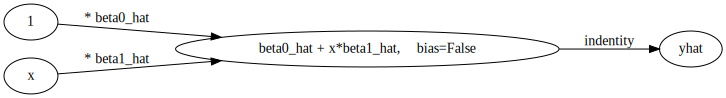

In [11]:
gv(''' 
    "1" -> "beta0_hat + x*beta1_hat,    bias=False"[label="* beta0_hat"]
    "x" -> "beta0_hat + x*beta1_hat,    bias=False"[label="* beta1_hat"]
    "beta0_hat + x*beta1_hat,    bias=False" -> "yhat"[label="indentity"]
    ''')

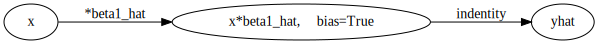

In [7]:
gv('''
"x" -> "x*beta1_hat,    bias=True"[label="*beta1_hat"] ;
"x*beta1_hat,    bias=True" -> "yhat"[label="indentity"] ''')


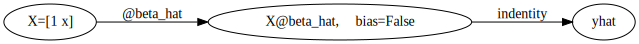

In [8]:
gv('''
"X=[1 x]" -> "X@beta_hat,    bias=False"[label="@beta_hat"] ;
"X@beta_hat,    bias=False" -> "yhat"[label="indentity"] ''')


#### 풀이1: 벡터버전, 사용자정의 손실함수 

`-` 포인트
```python
## 포인트코드1: 네트워크 생성 
net = tf.keras.Sequential()

## 포인트코드2: 네트워크의 아키텍처 설계 
net.add(tf.keras.layers.Dense(1,input_shape=(2,),use_bias=False)) 

## 포인트코드3: 네트워크 컴파일 = 아키텍처 + 손실함수 + 옵티마이저
net.compile(opt,loss=loss_fn2)

## 포인트코드4: 미분 & update 
net.fit(X,y,epochs=1000,verbose=0,batch_size=N) 
```

#### 풀이2: 벡터버전, net.compile의 옵션으로 손실함수 지정 

`-` 포인트
```python
## 포인트코드: 네트워크 컴파일 = 아키텍처 + 손실함수 + 옵티마이저
net.compile(opt,loss='mse') # net.compile의 옵션으로 손실함수 지정 
```

#### 풀이3: 스칼라버전, net.compile의 옵션으로 손실함수 지정 

`-` 포인트
```python
## 포인트코드: use_bias=True
net.add(tf.keras.layers.Dense(1,input_shape=(1,),use_bias=True)) 
```

### tf.keras.Model

#### 풀이1: 벡터버전

`-` 포인트 
```python
## 포인트코드: 네트워크 설계 (Xi -> yihat의 과정을 공책에 쭉 쓰는 느낌)
Xi = tf.keras.layers.Input(shape=(2,)) 
l1 = tf.keras.layers.Dense(units=1,input_shape=(2,),use_bias=False) 
yihat = l1(Xi) 
net = tf.keras.Model(Xi,yihat)
```

#### 풀이2: 스칼라버전 

`-` 포인트 
```python
## 포인트코드: 네트워크 설계 (입력차원 조심, 바이어스 조심) 
xi = tf.keras.layers.Input(shape=(1,)) 
l1 = tf.keras.layers.Dense(units=1,input_shape=(1,),use_bias=True)
```